#  ADC MS9280
- 10-bit
- 35 MSPS
- sample annd hold amplifier
- single-ended OR differential inputs
- Range selection / offset selection
- Tristate voltage (1, 0, high-Z)

## Examples

### bolt: MSMS9280 
#### Device functionality
- Voltage glitcher (can pull voltages to ground at very high speeds)
- Differential power analysis oscilloscope
- 8-channel logic analyzer (with GPIO's connected directly to RP2040, frequencies up to 200 MHz)

<img src="images/ms9280_bolt.png" width="1000" height="400" />

#### ADC Mode configuration (Top / Bottom)
- AIN: input connection
- Mode pin: AVDD = 3.3 V
- REFSENSE pin: Grounded
- REFTS, VREF: shorted
- REFBS: grounded
- AIN: 2 V (reference voltage 2 V)
#### ADC Input clock
- Generated by an MCO of the RP2040

#### Clamp-pin
- CLAMPIN: unconnected
- CLAMP: grounded

#### REFBF / REFTF
- 0.1 uF for each between GNDA and pin
- 10 uF and 0.1 uF between the 2 lines

### glitching_fmaw: MS9280

<img src="images/ms9280_glitching_fmaw.png" width="1000" height="400" />

### AD9280 Evaluation board
https://download.datasheets.com/pdfs/2010/8/23/1/49/52/396/adi_/manual/ad9280.pdf

<img src="images/ms9280_AD9280.png" width="700" height="400" />

### ADC Mode configuration (Top / Bottom)
- AIN: input connection
- Mode pin: AVDD (3.3 V)
- REFSENSE pin (Grounded)
- REFTS, VREF: Shorted
- REFBS: grounded
- AIN: 2 V

### Decoupling
#### REFBF / REFTF
- 0.1 uF for each between GNDA and pin
- 10 uF and 0.1 uF between the 2 lines


### Input pin filtering
#### ADC_AIN


## Execution

### ADC Mode choice

Choose the ADC to be in differential-mode by default:
- DC offset circuitry not needed
	- Introduces accuracy errors (exact shift unknown) and noise
- Common mode filtering (cancels out even harmonics)

**Settings**
- AIN -> input 1
- REFTS, REFBS shorted -> input 2
- Mode: AVDD / 2
- REFSENSE: 
	- VREF = 2  (default): [Connect REFSENSE to VREF]
	- VREF = 1  (switch): [Connect REFSENSE to AGND]
- REFTS, REFBS: AVDD / 2

**Default ADC connection is differential-mode, 2 V reference, top/bottom and center conections with 1/2 V reference are possible with jumper connections**

**!IMPORTANT: Make sure when routing to place differential jumpers as closely as possible**

### Decoupling / Filtering capacitors
#### REFTF / REFBF
- Top and bottom reference decoupling pins.


**0.1 uF (GNDA <=> pin), 10 uF, 0.1 uF (REFTF <=> REFBF), see examples + docs**

### ADC Input Clock
- Deliver it from the FPGA / MCU you choose
	- Set appropriately to change different modes
- It requires a 35 MHz signal with sharp edges, so pay attention to traces

**Delivery from FPGA**

### Tristate / STBY
- Should be low by default
- High: high-impedance state (add button)

**Connect to ground through closed jumper**

### OTR
Indicates whether the signal is out of range

**Connect to an FPGA input, and add testpoint**

### Mode
**Connect to Vdd/2 by default, have open soldering bridges for connection Vdd and GND**
- This way we can always decide to change the mode if necessary.

### Clamping

Is simply to force a DC bias on AIN
Not used in our case (can always be done externally as well)
- CLAMPIN: pin with the DC bias voltage to be superposed on AIN
- CLAMP: switches OPAMP output to AIN (imposes bias voltage from CLAMPIN)

![](images/clamp_circuit.png)

**Tie the CLAMP-pin low**
**Tie the CLAMPIN-pin to ground**

### AVSS, DRVSS
Digital and analog ground-

## ADC Input stage
### Why we need a differential resistor
- Twisted pair sees 2 DC bias resistors.
- Sees at sampling rates ADC's internal sampling caps of a few pF and ESD diodes.
- This is destined to cause oscillations with the line inductance ($f_0 = \frac{1}{2*\pi*\sqrt(L*C)}$), if not enough damping is applied.
- Placing a differential resistor in parallel with the lines dampens the oscillations.

#### Why don't we use series resistors
- Imbalance between resistors messes up the signal
- More effective damping
- Voltage drop over the series resistor
- Matching with differential tranmission line, which is often 100 ohms.


### Why do we bias both pins
- The 2 inputs need to be connected either through a transformer or a resistor termination.
- In a differential ADC both pins are biased to Vref/2.
	- Since the OPAMP can only handle voltages between 0 and Vref.
	- Later the Vref/2 is then added so you end-up mid-scale

### Options for input stage
#### Baluns + differential resistance option
- We need to add a 1:1 balun in order to isolate the DC bias of the analog front-end from the connector.
- We need to bring both pins onto a Vdd/2 bias level, and we need a differential termination there as well.
- The 100 ohm termination can be connected in parallel with the balun.
	- Balun has a parallel magnetizing inductance, make sure it looks like an open circuit at MHz frequencies.

**It seems the balun-configuration is mostly a configuration type used for higher frequencies**

#### Input caps + differential resistance option
- Simply put 2 DC-blocking caps (33-100nF) in series with the signal
	- Cutoff frequency fc = 1 / (2*pi*50*C) (with 100 ohm differential input impedance)

In [2]:
import math

f_flat = 30e3
r_diff = 100
w_flat = 2*math.pi*f_flat

c_required = 1/(w_flat * r_diff/2)
print(f"Series capacitance {c_required*1e9} nF for f_plateau {f_flat*1e-6} MHz")

Series capacitance 106.1032953945969 nF for f_plateau 0.03 MHz


In [8]:
c_chosen = 100e-9
r_diff = 100

f_flat = 1/(c_chosen * r_diff/2 * 2 * math.pi)
print(f"Series capacitance {c_chosen*1e9} nF for f_plateau {f_flat*1e-6} MHz")

Series capacitance 100.0 nF for f_plateau 0.031830988618379075 MHz


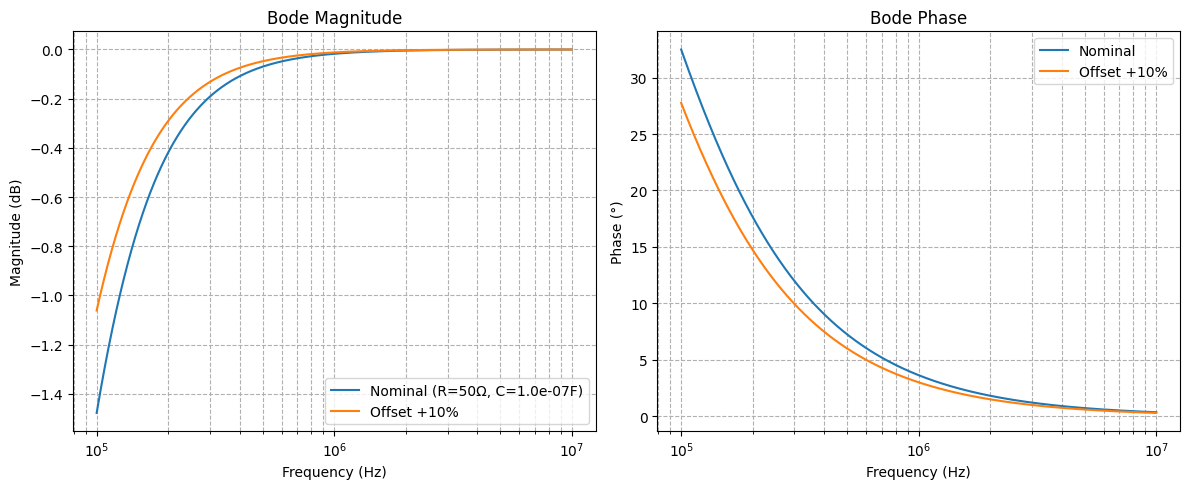

Gain difference drops to -0.1 dB (0.1) 229.2769312865649 kHz
Phase difference drops below 3 degrees at 194.21746814890244 kHz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Nominal component values and offset percentage
R_nom = r_diff / 2    # Ohms
C_nom = 100e-9   # Farads
offset_percent = 10  # Percentage offset

# Offset values
R_off = R_nom * (1 + offset_percent / 100)
C_off = C_nom * (1 + offset_percent / 100)

# Frequency sweep
f = np.logspace(5, 7, 1000)
w = 2 * np.pi * f

# Transfer functions for two filters
H1 = (1j * w * R_nom * C_nom) / (2 + 1j * w * R_nom * C_nom)
H2 = (1j * w * R_off * C_off) / (2 + 1j * w * R_off * C_off)

# Calculate magnitude (dB) and phase (degrees)
mag1 = 20 * np.log10(np.abs(H1))
phase1 = np.angle(H1, deg=True)
mag2 = 20 * np.log10(np.abs(H2))
phase2 = np.angle(H2, deg=True)

# Plotting on shared subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Combined magnitude plot
axes[0].semilogx(f, mag1, label=f'Nominal (R={R_nom:.0f}Ω, C={C_nom:.1e}F)')
axes[0].semilogx(f, mag2, label=f'Offset +{offset_percent}%')
axes[0].set_title('Bode Magnitude')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude (dB)')
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--')

# Combined phase plot
axes[1].semilogx(f, phase1, label='Nominal')
axes[1].semilogx(f, phase2, label=f'Offset +{offset_percent}%')
axes[1].set_title('Bode Phase')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Phase (°)')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--')

plt.tight_layout()
plt.show()

mag_rel_diff = np.where((mag1-mag2) >= -0.1)
phase_diff = np.where(phase1 - phase2 <= 3)

print(f"Gain difference drops to -0.1 dB (10**(0.1 / 20) = .01) {min(f[mag_rel_diff])*1e-3} kHz")
print(f"Phase difference drops below 3 degrees at {min(f[phase_diff])*1e-3} kHz")

**So the main issue with having input capacitors is the phase-shift that happens in the frequency range of 100 kHz to 10 MHz, we can however digitize the signal and perform digital phase-shifting by measuring the input characteristics with a frequency sweep and implementing a filter-on-fpga later-on. Also if we take larger capacitors we risk being in the inductive region.**

#### 2 resistors to vref / 2 vs single 100 ohm resistor
The ADC schematic indicates a direct connection from AIN- to vref / 2, but it is perhaps better to bias both pins with a 50 ohm resistor separately.
This is indeed what is done in the AD9280 example, and also what is done in the MS9280 example cirucit. 
	- Both inputs are externally biased to Vdd / 2.

**Use 50 ohm, <= 1 % accurate resistors, calibrate on connection.**
**Use 2 series 330 nF capacitors, calibrate phase-shift on connection.**

#### What about offsets between capacitors
Possible offset between capacitors is about 10 %. So let's say we choose a 100 nF capacitor, with an offset of about 20 nF.
Then there would be a
- Gain offset between the 2 inputs (barely noticeable at 1 MHz)
- A phase-offset between the 2 inputs (max about 1 degree at 1 MHz)

So make sure to choose a 0.5 - 1 % accurate capacitor


## Input connector
- IEC 60603-7, TIA/EIA-568 (ANSI/TIA-568-B.2, Cat 5e / Cat 6): by default a 100 ohm up to 100 MHz, +-- 15 % balanced twisted pair cable.
- Pick the cheapest one which has a footprint already available in KiCad
Vendors: RJ45Receptacle, Amphenol ICC, RCH, Wurth Elektronik, Bel Fuse, CONNFLY Elec, HANRUN(Zhongshan HanRun Elec), Kycon, MOLEX, Pulse Elec, UDE Corp, Abracon LLC, METZ CONNECT GmbH, HALO ELECTRONICS

### Sources:
- https://ww1.microchip.com/downloads/aemDocuments/documents/MCU08/ProductDocuments/SupportingCollateral/Differential-and-Single-Ended-ADC-WhitePaper-DS00003197A.pdf

# Preamplifier

## Fully differential amplifier
### Resistor matching
- LT5400A
